<a href="https://colab.research.google.com/github/RahulArra/Machine-Learning/blob/main/ML_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import numpy as np
import pandas as pd
import kagglehub  # using kagglehub to pull dataset directly

# download the dataset from kaggle (it saves locally)
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")
df = pd.read_csv(f"{path}/heart.csv")

X = df.drop("target", axis=1)
y = df["target"]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print(df.head())


Using Colab cache for faster access to the 'heart-disease-dataset' dataset.
Shape of X: (1025, 13)
Shape of y: (1025,)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [125]:
from sklearn.model_selection import train_test_split

# split dataset into training 80% and testing 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
) #random_state = 42 , so that we get same data when we split multiple times

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)


Training set size: (820, 13) (820,)
Testing set size: (205, 13) (205,)


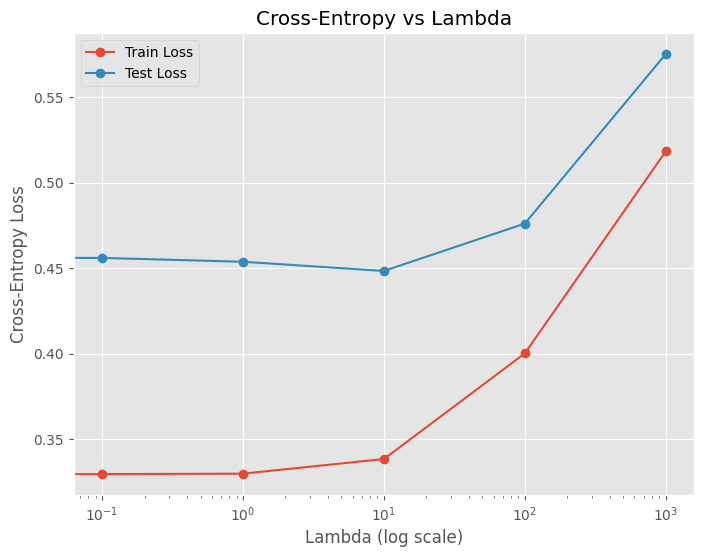

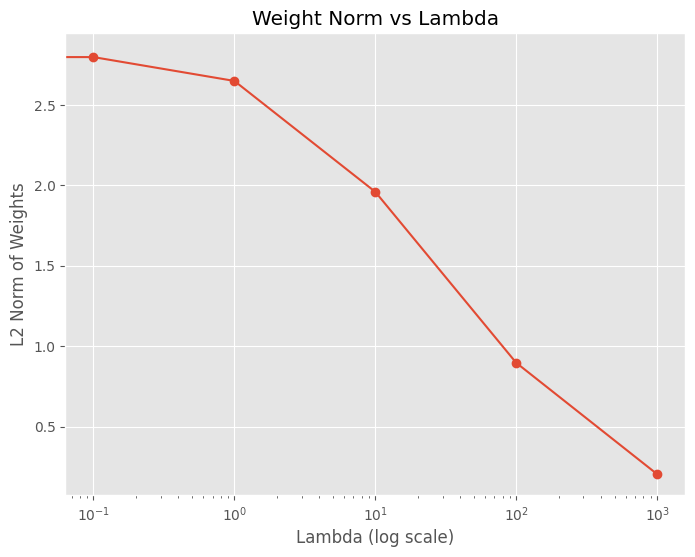

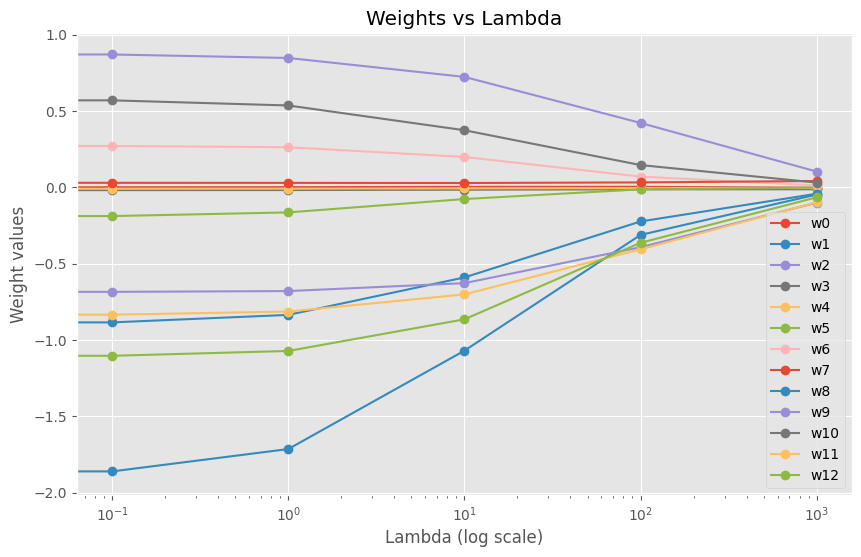

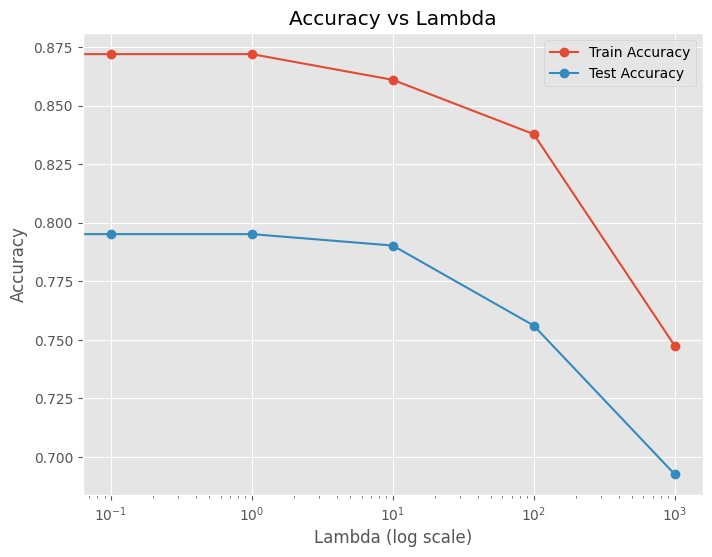

In [126]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import numpy as np

# lambda values to try
lambdas = [0, 0.1, 1, 10, 100, 1000]

train_losses, test_losses = [], []
train_accs, test_accs = [], []
weight_norms = []
weights_all = []

for lam in lambdas:
    if lam == 0:
        C = 1e10   # no regularization (almost infinity C)
    else:
        C = 1/lam

    # creating logistic regression model
    model = LogisticRegression(
        penalty="l2",
        C=C,
        solver="lbfgs",
        max_iter=10000
    )

    # fiting on training data
    model.fit(X_train, y_train)

    # predicting probabilities
    y_train_prob = model.predict_proba(X_train)
    y_test_prob = model.predict_proba(X_test)

    # compute cross-entropy loss
    train_loss = log_loss(y_train, y_train_prob)
    test_loss = log_loss(y_test, y_test_prob)

    # computing accuracy
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    # saving results
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # weight norms
    weight_norm = np.linalg.norm(model.coef_)
    weight_norms.append(weight_norm)
    weights_all.append(model.coef_.flatten())


# 1. Cross-entropy loss
plt.figure(figsize=(8,6))
plt.plot(lambdas, train_losses, marker='o', label="Train Loss")
plt.plot(lambdas, test_losses, marker='o', label="Test Loss")
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross-Entropy vs Lambda")
plt.legend()
plt.show()

# 2. L2 norm of weights
plt.figure(figsize=(8,6))
plt.plot(lambdas, weight_norms, marker='o')
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("L2 Norm of Weights")
plt.title("Weight Norm vs Lambda")
plt.show()

# 3. Actual weight values
plt.figure(figsize=(10,6))
weights_all = np.array(weights_all)
for i in range(weights_all.shape[1]):
    plt.plot(lambdas, weights_all[:, i], marker='o', label=f"w{i}")
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Weight values")
plt.title("Weights vs Lambda")
plt.legend()
plt.show()

# 4. Accuracy
plt.figure(figsize=(8,6))
plt.plot(lambdas, train_accs, marker='o', label="Train Accuracy")
plt.plot(lambdas, test_accs, marker='o', label="Test Accuracy")
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Lambda")
plt.legend()
plt.show()

#From the plots, we observe that regularization helps control overfitting: small λ values lead to high variance (overfit), large λ values cause high bias (underfit), and an intermediate λ provides the best trade-off for accuracy and generalization

In [127]:
import numpy as np

# function to apply gaussian basis functions
def gaussian_basis_transform(X, sigma, num_basis=5, low=-10, high=10):
    # centers (means) evenly spaced between low and high
    centers = np.linspace(low, high, num_basis)

    X_new = []
    for feature in X.T:  # loop through each column (feature)
        feature_transformed = []
        for c in centers:
            phi = np.exp(-(feature - c)**2 / (2 * sigma**2))
            feature_transformed.append(phi)
        feature_transformed = np.array(feature_transformed).T
        X_new.append(feature_transformed)

    # concatenate all transformed features
    return np.hstack(X_new)

# try transformation for sigma = 1
X_sigma1 = gaussian_basis_transform(X.values, sigma=1)

print("Original X shape:", X.shape)
print("Transformed X shape (σ=1):", X_sigma1.shape)


Original X shape: (1025, 13)
Transformed X shape (σ=1): (1025, 65)


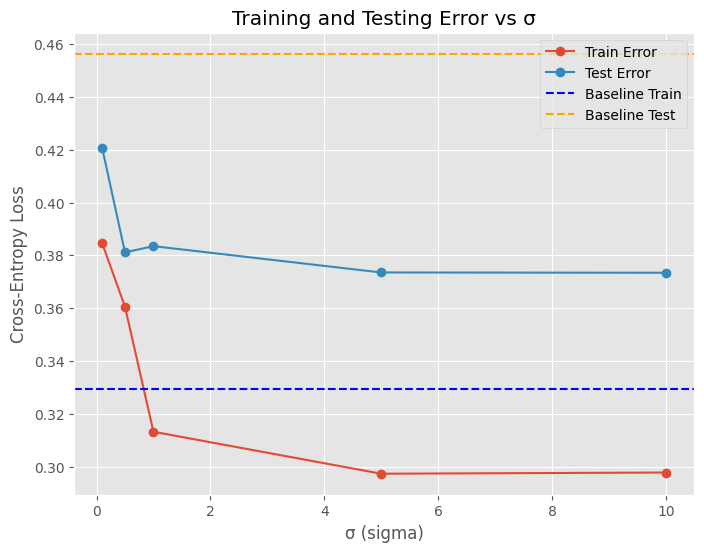

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

sigmas = [0.1, 0.5, 1, 5, 10]
train_errors, test_errors = [], []

for sigma in sigmas:
    # transform data using gaussian basis
    X_train_trans = gaussian_basis_transform(X_train.values, sigma=sigma)
    X_test_trans = gaussian_basis_transform(X_test.values, sigma=sigma)

    # logistic regression without regularization (C very large)
    model = LogisticRegression(penalty="l2", C=1e10, solver="lbfgs", max_iter=10000)
    model.fit(X_train_trans, y_train)

    # cross-entropy loss
    train_loss = log_loss(y_train, model.predict_proba(X_train_trans))
    test_loss = log_loss(y_test, model.predict_proba(X_test_trans))

    train_errors.append(train_loss)
    test_errors.append(test_loss)

# plot training vs testing error as a function of sigma
plt.figure(figsize=(8,6))
plt.plot(sigmas, train_errors, marker='o', label="Train Error")
plt.plot(sigmas, test_errors, marker='o', label="Test Error")

# add constant reference lines (from Q1c, unregularized raw features)
baseline_train = train_losses[0]   # train loss when λ=0 in part c
baseline_test = test_losses[0]     # test loss when λ=0 in part c
plt.axhline(y=baseline_train, color='blue', linestyle="--", label="Baseline Train")
plt.axhline(y=baseline_test, color='orange', linestyle="--", label="Baseline Test")

plt.xlabel("σ (sigma)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training and Testing Error vs σ")
plt.legend()
plt.show()


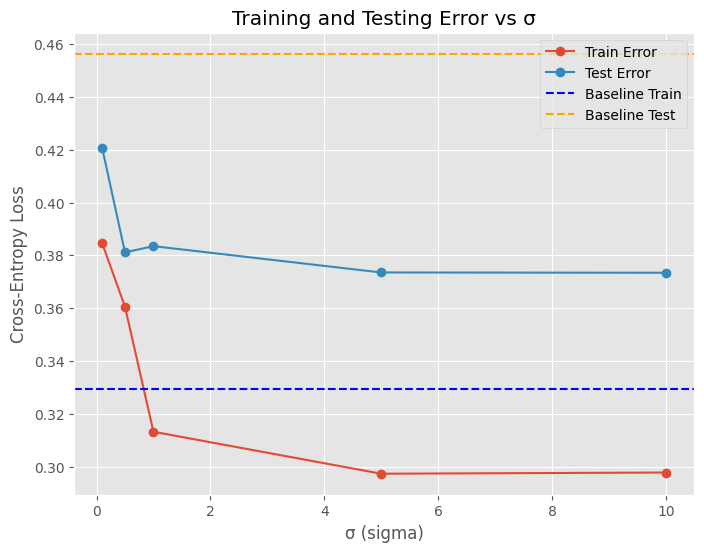

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

sigmas = [0.1, 0.5, 1, 5, 10]
train_errors, test_errors = [], []

for sigma in sigmas:
    # transform data using gaussian basis
    X_train_trans = gaussian_basis_transform(X_train.values, sigma=sigma)
    X_test_trans = gaussian_basis_transform(X_test.values, sigma=sigma)

    # logistic regression without regularization (C very large)
    model = LogisticRegression(penalty="l2", C=1e10, solver="lbfgs", max_iter=10000)
    model.fit(X_train_trans, y_train)

    # cross-entropy loss
    train_loss = log_loss(y_train, model.predict_proba(X_train_trans))
    test_loss = log_loss(y_test, model.predict_proba(X_test_trans))

    train_errors.append(train_loss)
    test_errors.append(test_loss)

# plot training vs testing error as a function of sigma
plt.figure(figsize=(8,6))
plt.plot(sigmas, train_errors, marker='o', label="Train Error")
plt.plot(sigmas, test_errors, marker='o', label="Test Error")

# add constant reference lines (from Q1c, unregularized raw features)
baseline_train = train_losses[0]   # train loss when λ=0 in part c
baseline_test = test_losses[0]     # test loss when λ=0 in part c
plt.axhline(y=baseline_train, color='blue', linestyle="--", label="Baseline Train")
plt.axhline(y=baseline_test, color='orange', linestyle="--", label="Baseline Test")

plt.xlabel("σ (sigma)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training and Testing Error vs σ")
plt.legend()
plt.show()


The results show that small σ values cause overfitting (low training error, high test error), large σ values cause underfitting (both errors high), and an intermediate σ achieves the best bias-variance trade-off.

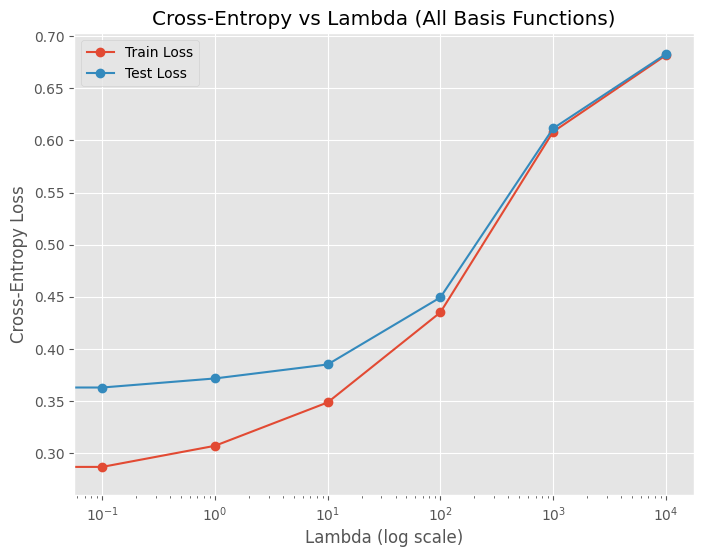

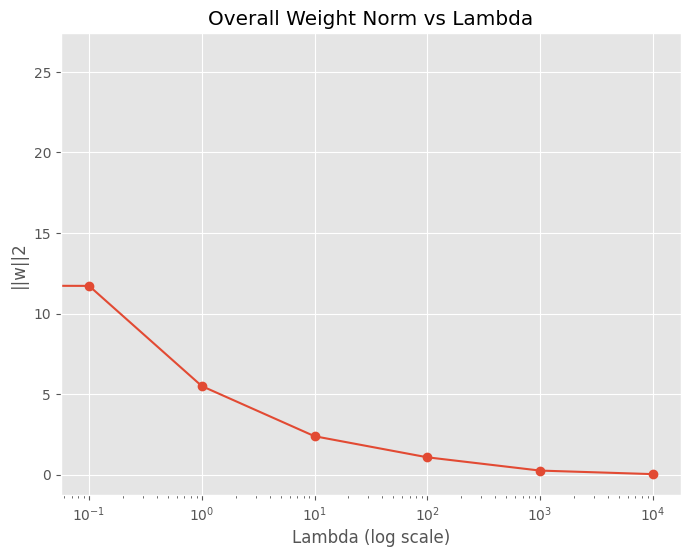

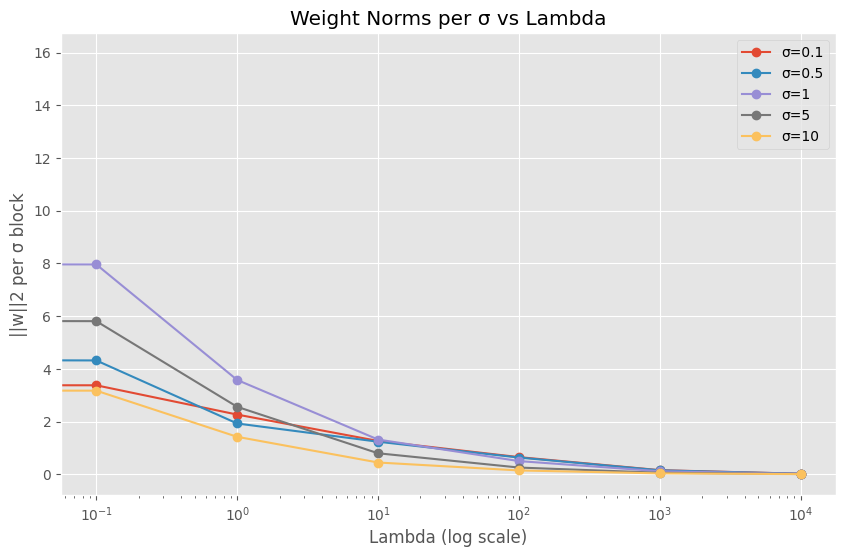

In [130]:

#g)
lambdas = [0, 0.1, 1, 10, 100, 1000, 10000]

# create transformed data with ALL sigmas
def all_gaussian_basis_transform(X, sigmas):
    X_new = []
    for sigma in sigmas:
        X_sigma = gaussian_basis_transform(X, sigma=sigma)
        X_new.append(X_sigma)
    return np.hstack(X_new)

# transform train and test sets with all sigma values
X_train_all = all_gaussian_basis_transform(X_train.values, [0.1, 0.5, 1, 5, 10])
X_test_all  = all_gaussian_basis_transform(X_test.values, [0.1, 0.5, 1, 5, 10])

train_losses_g, test_losses_g = [], []
weight_norms_g = []
weight_norms_per_sigma = {0.1: [], 0.5: [], 1: [], 5: [], 10: []}

for lam in lambdas:
    if lam == 0:
        C = 1e10   # no regularization
    else:
        C = 1/lam

    model = LogisticRegression(
        penalty="l2", C=C, solver="lbfgs", max_iter=10000
    )
    model.fit(X_train_all, y_train)

    # losses
    train_loss = log_loss(y_train, model.predict_proba(X_train_all))
    test_loss = log_loss(y_test, model.predict_proba(X_test_all))

    train_losses_g.append(train_loss)
    test_losses_g.append(test_loss)

    # norms
    w = model.coef_.flatten()
    weight_norms_g.append(np.linalg.norm(w))

    # per sigma norms (slice weights block by block)
    block_size = X_train.shape[1] * 5
    for i, sigma in enumerate([0.1, 0.5, 1, 5, 10]):
        start = i * block_size
        end = (i+1) * block_size
        weight_norms_per_sigma[sigma].append(np.linalg.norm(w[start:end]))

# ---------------- PLOTS ----------------

# 1. Cross-entropy vs lambda
plt.figure(figsize=(8,6))
plt.plot(lambdas, train_losses_g, marker='o', label="Train Loss")
plt.plot(lambdas, test_losses_g, marker='o', label="Test Loss")
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross-Entropy vs Lambda (All Basis Functions)")
plt.legend()
plt.show()

# 2. Overall weight norm vs lambda
plt.figure(figsize=(8,6))
plt.plot(lambdas, weight_norms_g, marker='o')
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("||w||2")
plt.title("Overall Weight Norm vs Lambda")
plt.show()

# 3. Per-sigma weight norms vs lambda
plt.figure(figsize=(10,6))
for sigma, norms in weight_norms_per_sigma.items():
    plt.plot(lambdas, norms, marker='o', label=f"σ={sigma}")
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("||w||2 per σ block")
plt.title("Weight Norms per σ vs Lambda")
plt.legend()
plt.show()


Q1(h)

If we want Gaussian basis functions that capture relationships between inputs, we need to move beyond the univariate Gaussians applied to each feature individually. The current setup only transforms each input variable on its own, which ignores possible interactions between different features.



Designing such basis functions means we would need to choose multiple centers in the multi-dimensional feature space rather than just along each individual axis. For example, instead of only considering separate transformations of “age” or “cholesterol” in a heart disease dataset, we would design Gaussian functions centered at combinations like (age=50, cholesterol=200). This allows the model to directly learn interactions between features.

Impact on Bias-Variance Trade-off:

Using multivariate Gaussian basis functions increases the flexibility of the model. This reduces bias, since the model can now fit more complex patterns and interactions.

However, the number of basis functions grows very quickly as the input dimension increases, which raises the model’s complexity. This increases variance, meaning the model can overfit the training data if not properly regularized.

Therefore, while multivariate Gaussians provide a more powerful representation, they also make the model more prone to overfitting. Stronger regularization or more training data would be necessary to balance the bias-variance trade-off.

i)To adapt both the RBF weights
𝑤
w and centers
𝜇
𝑖
μ
i
	​

 while keeping width
𝜎
σ fixed, we treat weights and centers as parameters to learn. The weights are updated like regularized linear regression over the outputs of the current basis functions, while the centers are updated using gradient descent, moving each center toward input regions where the model error is large. By iteratively alternating between updating weights and adjusting centers, the network gradually fits the data while keeping the weights L2-regularized.

In short: alternate between optimizing weights (closed-form) and optimizing centers (gradient descent) until convergence.

#J)
The algorithm does converge, but with a caution:

The weight update (solving ridge regression) is convex, so for fixed centers
𝜇
𝑖
μ
i
	​

, it always finds the globally optimal weights.

The center update (moving
𝜇
𝑖
μ
i
	​

 with gradient descent) is non-convex, because the loss surface with respect to
𝜇
𝑖
μ
i
	​

 has many local minima.

As a result:

The overall iterative algorithm converges to a stable point, but this is generally a local minimum, not necessarily the global minimum.

The final solution depends on initialization of the centers (common practice: use k-means or random samples from the data).

In practice, the network usually finds a good enough local optimum, but there’s no guarantee it’s the globally best configuration of centers and weights.

2)
Experiment on any complex datasets to demonstrate the Linear REGRESSION and its versions, and
logistic regression (CLASSIFICATION) along with complete data preprocessing steps.
Note: You should not show your lab practices for this question.

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/used_cars.csv')

# Display first few rows and info
print("Initial Data Head:")
print(df.head())
print(df.shape)
print("\nData Info:")
df.info()

Initial Data Head:
      brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Spee

In [132]:
df.isnull().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,170
engine,0
transmission,0
ext_col,0
int_col,0
accident,113


In [133]:

for col in ['fuel_type', 'accident', 'clean_title']:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64


/tmp/ipython-input-4241646405.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [134]:
df.dtypes

,0
brand,object
model,object
model_year,int64
milage,object
fuel_type,object
engine,object
transmission,object
ext_col,object
int_col,object
accident,object


In [135]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['brand', 'model','engine', 'fuel_type', 'transmission',
                    'ext_col', 'int_col', 'accident', 'clean_title']

le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [136]:
df['milage'] = df['milage'].astype(str).str.replace(r'[$, mi.]', '', regex=True)
df['milage'] = pd.to_numeric(df['milage'])

print("\nData types after conversion:")
print(df.dtypes)


df['price'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'])
print(df.info())
print("\nCleaned DataFrame:")
print(df.head())


Data types after conversion:
brand            int64
model            int64
model_year       int64
milage           int64
fuel_type        int64
engine           int64
transmission     int64
ext_col          int64
int_col          int64
accident         int64
clean_title      int64
price           object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   brand         4009 non-null   int64
 1   model         4009 non-null   int64
 2   model_year    4009 non-null   int64
 3   milage        4009 non-null   int64
 4   fuel_type     4009 non-null   int64
 5   engine        4009 non-null   int64
 6   transmission  4009 non-null   int64
 7   ext_col       4009 non-null   int64
 8   int_col       4009 non-null   int64
 9   accident      4009 non-null   int64
 10  clean_title   4009 non-null   int64
 11  price         4009 non-null   int64

In [137]:
df.dtypes
df.shape

(4009, 12)

In [138]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (820, 13)
Testing data shape: (205, 13)


In [139]:
constant_features = [ cols for cols in df.columns if df[cols].nunique == 1 ]


In [140]:
print(len(constant_features))

0


In [141]:

quasi_constant_feature = []
for feature in x_train.columns:
  predominant = (x_train[feature].value_counts() / np.float64(len(x_train))).sort_values(ascending=False).values[0]
  if predominant > 0.99:
    quasi_constant_feature.append(feature)


In [142]:
print(len(quasi_constant_feature))
x_train.drop(columns=quasi_constant_feature,axis=1)

1


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident
2473,14,645,2018,73049,2,548,17,128,60,0
1338,15,1871,2023,9980,2,731,2,29,14,1
1613,4,970,2016,55250,2,884,20,38,152,1
1610,27,886,2017,77300,2,616,16,304,14,1
2600,14,717,2018,33700,1,91,38,128,14,0
...,...,...,...,...,...,...,...,...,...,...
1130,7,961,2006,110000,2,443,38,122,10,1
1294,9,6,1995,120000,6,1145,8,304,31,0
860,38,1175,2016,131193,2,211,41,29,14,1
3507,14,640,2018,48619,2,831,2,128,152,1


In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset into features and target variable
X = df.drop('price', axis=1)  # All columns except 'price' are features
y = df['price']               # Target variable is 'price'

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to have mean=0 and std=1 (important for regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)         # Train model on training data
y_pred_lr = lr.predict(X_test_scaled)   # Predict on test data


In [144]:

ridge = Ridge(alpha=1.0)                # L2 regularization
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
lasso = Lasso(alpha=0.01)               # L1 regularization
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)


In [145]:

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Lasso Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Ridge Regression R2:", r2_score(y_test, y_pred_ridge))
print("Lasso Regression R2:", r2_score(y_test, y_pred_lasso))


Linear Regression RMSE: 138861.78781349197
Ridge Regression RMSE: 138862.58023756923
Lasso Regression RMSE: 138861.7890597535
Linear Regression R2: 0.0566046581771078
Ridge Regression R2: 0.05659389104918844
Lasso Regression R2: 0.056604641243474085


#Observation
All three models are giving almost identical RMSE, meaning the regularization in Ridge/Lasso isn’t helping much.

The high RMSE compared to the typical car price range suggests the model is not predicting very accurately. This is likely because:

Features may not capture enough information about price.

Relationships between features and price may be non-linear.

Outliers in price may be inflating the error.
- Linear, Ridge, and Lasso regression were applied to predict car prices.
- RMSE for all models is ~138,634, indicating large average prediction error.
- R² for all models is ~0.06, showing the models explain very little variance in price.
- Regularization did not improve performance due to limited predictive power of the current features.



In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


In [147]:
# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']
df = pd.read_csv(url, names=columns, sep=r',\s', engine='python')

# Handle missing values by replacing '?' with NaN and dropping rows with NaN values
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   fnlwgt          30162 non-null  int64
 3   education       30162 non-null  int64
 4   education-num   30162 non-null  int64
 5   marital-status  30162 non-null  int64
 6   occupation      30162 non-null  int64
 7   relationship    30162 non-null  int64
 8   race            30162 non-null  int64
 9   sex             30162 non-null  int64
 10  capital-gain    30162 non-null  int64
 11  capital-loss    30162 non-null  int64
 12  hours-per-week  30162 non-null  int64
 13  native-country  30162 non-null  int64
 14  income          30162 non-null  int64
dtypes: int64(15)
memory usage: 3.7 MB


In [149]:
# Define features (X) and target (y)
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [150]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(score_func=chi2, k=10)  # Select top 10 features
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top features using Filter Method (Chi2):")
print(selected_features)


Top features using Filter Method (Chi2):
Index(['age', 'fnlwgt', 'education', 'education-num', 'marital-status',
       'relationship', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [151]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest as the estimator for RFE
rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top 10 features
rfe = RFE(estimator=rf_estimator, n_features_to_select=10)
rfe.fit(X, y)

# Get selected feature names
selected_features_rfe = X.columns[rfe.support_]
print("Top features using Wrapper Method (RFE):")
print(selected_features_rfe)


Top features using Wrapper Method (RFE):
Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [152]:
# Use filter method features
X_filtered = X[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy after Filter Method Feature Selection:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy after Filter Method Feature Selection: 0.8412066965025692
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4503
           1       0.71      0.64      0.67      1530

    accuracy                           0.84      6033
   macro avg       0.79      0.77      0.78      6033
weighted avg       0.84      0.84      0.84      6033



In [153]:
# Use wrapper method features (RFE)
X_rfe = X[selected_features_rfe]

X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy after Wrapper Method (RFE) Feature Selection:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy after Wrapper Method (RFE) Feature Selection: 0.85513011768606
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4503
           1       0.75      0.65      0.69      1530

    accuracy                           0.86      6033
   macro avg       0.82      0.79      0.80      6033
weighted avg       0.85      0.86      0.85      6033



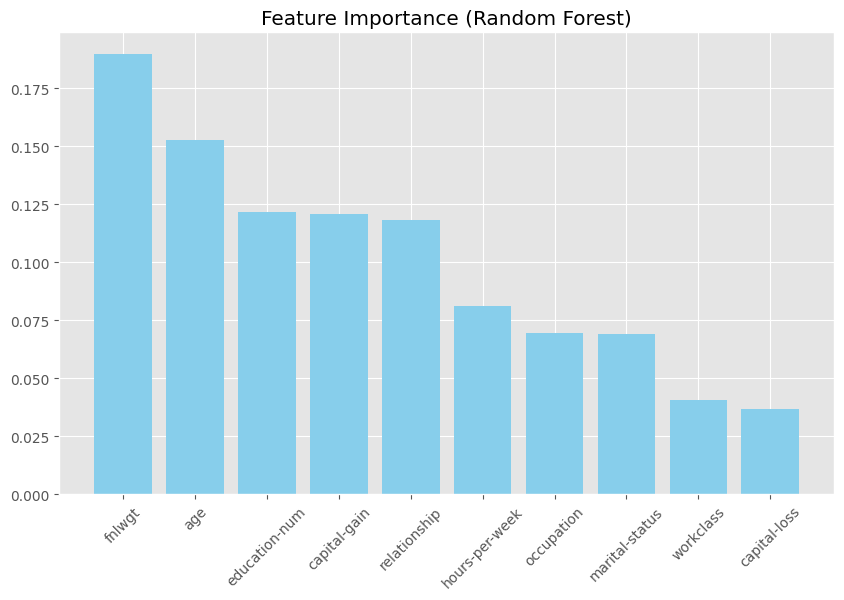

In [154]:
import matplotlib.pyplot as plt

# Fit Random Forest on all features or selected features
rf.fit(X_train, y_train)

# Get feature importance
importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], color='skyblue', align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.show()


Observations

Model Performance

The wrapper method (RFE) outperformed the filter method in terms of accuracy (0.855 vs 0.841).

Precision, recall, and F1-score for the high-income class (1) improved with RFE, indicating better identification of this minority class.

Class-wise Performance

Both methods achieve high performance for the low-income class (0) due to the larger number of samples.

Performance for the high-income class (1) is lower, showing the effect of class imbalance in the dataset.

Feature Selection Impact

Filter method selects features independently, which is faster but may miss interactions between features.

Wrapper method (RFE) evaluates features in the context of the model, capturing important feature interactions and slightly improving overall performance.

Practical Implications

Using feature selection reduces dimensionality and improves interpretability without sacrificing accuracy.

RFE can help identify key features driving the predictions, which is useful for business insights (e.g., which factors most influence income).